<a href="https://colab.research.google.com/github/jsebastianquiroga/Semestre_3/blob/main/NLP/TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

In [9]:
#Tokenizar
sentences = [
    'Amo a mi perro',
    'Amo a mi gato',
    'Tu amas a mi perro!'
]

tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print(word_index)

{'a': 1, 'mi': 2, 'amo': 3, 'perro': 4, 'gato': 5, 'tu': 6, 'amas': 7}


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentences = [
    'I love my dog',
    'I love my cat',
    'You love my dog!',
    'Do you think my dog is amazing?'
]

tokenizer = Tokenizer(num_words = 100, oov_token="<OOV>") #"<OOV>"crea un nuevo token para las que conoce los datos
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(sentences)

padded = pad_sequences(sequences, maxlen=5)
print("\nWord Index = " , word_index)
print("\nSequences = " , sequences)
print("\nPadded Sequences:")
print(padded)


Word Index =  {'<OOV>': 1, 'my': 2, 'love': 3, 'dog': 4, 'i': 5, 'you': 6, 'cat': 7, 'do': 8, 'think': 9, 'is': 10, 'amazing': 11}

Sequences =  [[5, 3, 2, 4], [5, 3, 2, 7], [6, 3, 2, 4], [8, 6, 9, 2, 4, 10, 11]]

Padded Sequences:
[[ 0  5  3  2  4]
 [ 0  5  3  2  7]
 [ 0  6  3  2  4]
 [ 9  2  4 10 11]]


In [11]:
# Try with words that the tokenizer wasn't fit to
test_data = [
    'i really love my dog',
    'my dog loves my manatee'
]

test_seq = tokenizer.texts_to_sequences(test_data)
print("\nTest Sequence = ", test_seq)

padded = pad_sequences(test_seq, maxlen=10)
print("\nPadded Test Sequence: ")
print(padded)


Test Sequence =  [[5, 1, 3, 2, 4], [2, 4, 1, 2, 1]]

Padded Test Sequence: 
[[0 0 0 0 0 5 1 3 2 4]
 [0 0 0 0 0 2 4 1 2 1]]


# RECONOCER SENTIMIENTOS CON TEXTO

In [14]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [15]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [17]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/sarcasm.json \
    -O /tmp/sarcasm.json


--2023-04-19 04:06:16--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 172.217.219.128, 209.85.146.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.07s   

2023-04-19 04:06:16 (77.4 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [18]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [19]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [20]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [21]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [23]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [24]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.6561 - accuracy: 0.6046 - val_loss: 0.5479 - val_accuracy: 0.7873 - 3s/epoch - 6ms/step
Epoch 2/30
625/625 - 4s - loss: 0.4148 - accuracy: 0.8374 - val_loss: 0.3888 - val_accuracy: 0.8264 - 4s/epoch - 6ms/step
Epoch 3/30
625/625 - 3s - loss: 0.3056 - accuracy: 0.8781 - val_loss: 0.3525 - val_accuracy: 0.8517 - 3s/epoch - 5ms/step
Epoch 4/30
625/625 - 2s - loss: 0.2555 - accuracy: 0.8993 - val_loss: 0.3472 - val_accuracy: 0.8514 - 2s/epoch - 3ms/step
Epoch 5/30
625/625 - 2s - loss: 0.2213 - accuracy: 0.9123 - val_loss: 0.3530 - val_accuracy: 0.8521 - 2s/epoch - 4ms/step
Epoch 6/30
625/625 - 2s - loss: 0.1927 - accuracy: 0.9263 - val_loss: 0.3604 - val_accuracy: 0.8508 - 2s/epoch - 4ms/step
Epoch 7/30
625/625 - 2s - loss: 0.1716 - accuracy: 0.9359 - val_loss: 0.3645 - val_accuracy: 0.8554 - 2s/epoch - 4ms/step
Epoch 8/30
625/625 - 3s - loss: 0.1521 - accuracy: 0.9445 - val_loss: 0.4063 - val_accuracy: 0.8404 - 3s/epoch - 6ms/step
Epoch 9/30
625/625 - 2s 

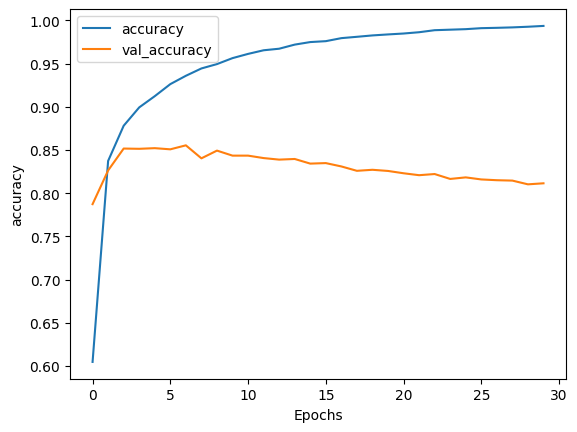

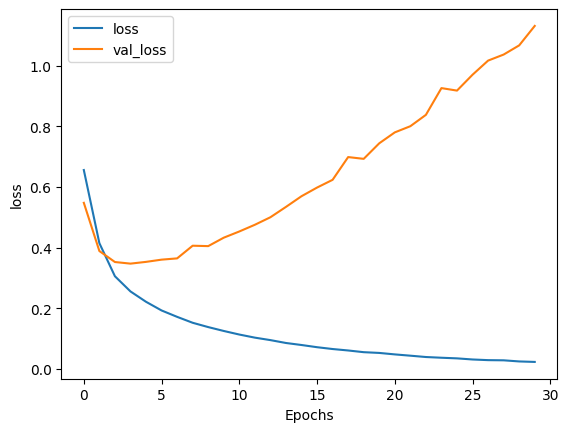

In [25]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [26]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [27]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [28]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [29]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 130ms/step
[[9.2531735e-01]
 [3.2318974e-06]]
